# Explore `glacier_mass_change`

Run this notebook via free cloud platforms:

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ezwelty/cds-notebooks/blob/main/glacier_mass_change.ipynb)

## Install and import packages

In [18]:
# Install cartopy on Colab
import os
if os.getenv('COLAB_RELEASE_TAG'):
    !pip install --no-binary shapely shapely --force
    !pip install cartopy

In [19]:
# Standard libraries
import pathlib
import urllib.request
import zipfile

# Extra libraries
import cartopy.crs
import matplotlib.pyplot
import xarray

## Download data

Since the data is not yet available via the Copernicus [Climate Data Store (CDS) API](https://cds.climate.copernicus.eu/api-how-to), we use a static version stored locally. All we have to do is unzip it.

In [20]:
pathlib.Path('temp').mkdir(exist_ok=True)
url = 'https://github.com/ezwelty/cds-notebooks/raw/main/data/C3S2_mass-change-product_version-wgms-fog-2022-09_updatedMay17.zip'
path = 'temp/C3S2_mass-change-product_version-wgms-fog-2022-09_updatedMay17.zip'

urllib.request.urlretrieve(url, path)
with zipfile.ZipFile(path, 'r') as file:
    file.extractall('temp')

## Read and inspect data

The data are formatted as multiple netCDF4 files, one for each year. They can be read as a single dataset using [`xarray`](https://docs.xarray.dev).

In [21]:
ds = xarray.open_mfdataset('temp/C3S2_mass-change-product_version-wgms-fog-2022-09_updatedMay17/*.nc4')
ds

<xarray.Dataset>
Dimensions:      (time: 46, lat: 360, lon: 720)
Coordinates:
  * time         (time) datetime64[ns] 1976-01-01 1977-01-01 ... 2021-01-01
  * lat          (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon          (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Data variables:
    Glacier      (time, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    Uncertainty  (time, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    title:         Global gridded annual glacier mass change product
    project:       Copernicus Climate Change Service (C3S) Essential Climate ...
    data_version:  version-wgms-fog-2022-09
    institution:   World Glacier Monitoring Service - Geography Department - ...
    created_by:    Dr. Ines Dussaillant   ines.dussaillant@geo.uzh.ch
    references:    Fluctuation of Glagiers (FoG) database version wgms-fog-20...
    citation:      
    Conventions:   CF Version CF-1.8
    comment:       Brief data description:Horizontal resolution:\t0.5° (latit...

## Plot map of mass change for the most recent year

We use [`matplotlib`](https://matplotlib.org/) and [`cartopy`](https://scitools.org.uk/cartopy/docs/latest) to plot the mean and uncertainty of the global mass change for each year.

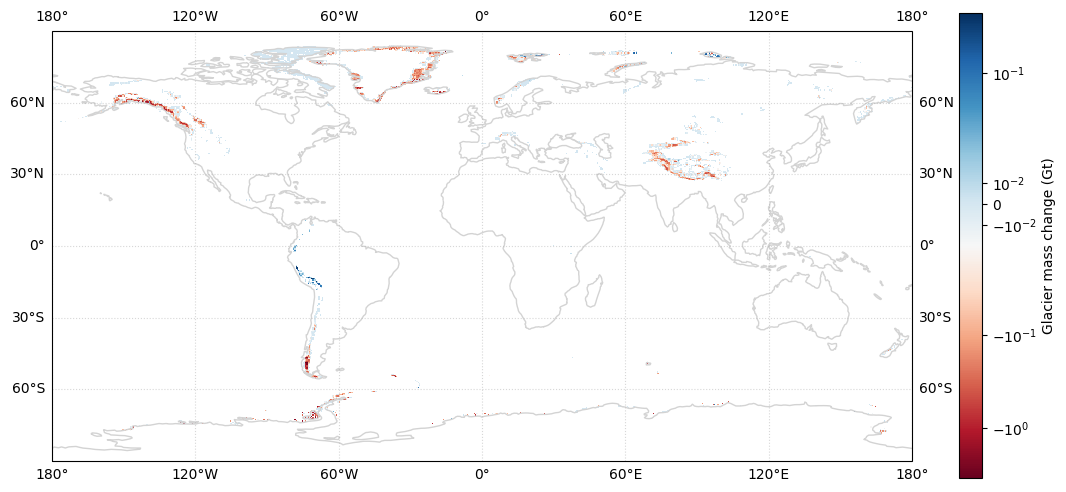

In [22]:
# Create a map with a plate carrée projection
figure = matplotlib.pyplot.figure(figsize=(12, 8))
axis = matplotlib.pyplot.axes(projection=cartopy.crs.PlateCarree())

# Add latitude, longitude gridlines
axis.gridlines(draw_labels=True, alpha=0.5, linestyle=':')

# Add coastlines
axis.coastlines(color='lightgrey')

# Plot mass change with a red (loss) – blue (gain) colormap on a log scale
im = matplotlib.pyplot.pcolormesh(
    ds['lon'],
    ds['lat'],
    ds['Glacier'][-1],
    cmap='RdBu',
    norm=matplotlib.colors.SymLogNorm(linthresh=0.05)
)

# Add a colourbar
cbar = matplotlib.pyplot.colorbar(im, fraction=0.025, pad=0.05, label='Glacier mass change (Gt)')

## Plot time series of global mass change

### Compute mean of global change

The global mass change is the sum of the mass changes reported for each spatial grid cell. We compute it by summing mass change across the latitude (`lat`) and longitude (`lon`) dimensions.

In [23]:
global_change_mean = ds.sum(dim=['lat', 'lon'])['Glacier']

### Compute standard deviation of global change

If we assume that the mass changes for which we computed the sum above are uncorrelated, the standard deviation of their sum is the square root of the sum of the squares of their standard deviatons:

$
f = \textstyle\sum_i m_i \\
\sigma_f = \sqrt {\textstyle\sum_i \sigma_i^2}
$

See [Wikipedia: Propagation of uncertainty](https://en.wikipedia.org/wiki/Propagation_of_uncertainty) for more information.

In [24]:
global_change_std = (ds['Uncertainty'] ** 2).sum(dim=['lat', 'lon']) ** 0.5

### Plot timeseries

We use [`matplotlib`](https://matplotlib.org/) to plot the mean and uncertainty of the global mass change for each year.

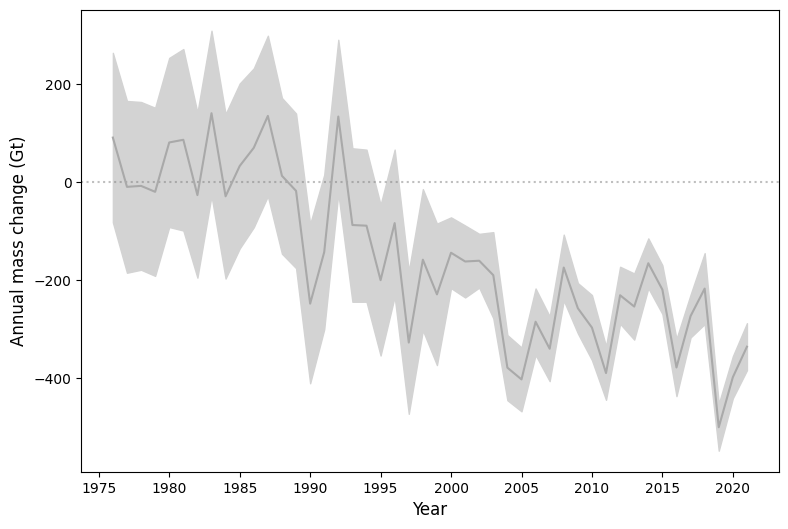

In [25]:
# Configure the figure
figure, axis = matplotlib.pyplot.subplots(1, 1, figsize=(9, 6))
axis.set_ylabel('Annual mass change (Gt)', fontsize=12)
axis.set_xlabel('Year', fontsize=12)

# Plot a horizontal line at 0 change
axis.axhline(y=0, alpha=0.5, linestyle=':', color='gray')

# Plot the uncertainty as 3 standard deviations below and above the mean
axis.fill_between(
    x=ds['time'],
    y1=global_change_mean - global_change_std * 3,
    y2=global_change_mean + global_change_std * 3,
    color='lightgray'
)

# Plot the mean as a line
axis.plot(
    ds['time'],
    global_change_mean,
    color='darkgray'
)